In [2]:
import pandas as pd
import geopandas as gpd
import pycountry
from matplotlib import pyplot as plt
import matplotlib.animation as animation

In [3]:
df = pd.read_csv('../data/life-expectancy/Life Expectancy Data.csv')
# print(df.isnull().sum())
status_dummies = pd.get_dummies(df['Status'], dtype=int)
df = pd.concat([df, status_dummies], axis=1)
df = df.drop(['Status'], axis=1)
df = df.infer_objects()
# print(df.dtypes)
df = df.groupby('Country').transform(pd.DataFrame.interpolate)
print(df.isnull().sum())

Year                                 0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            193
percentage expenditure               0
Hepatitis B                        144
Measles                              0
 BMI                                34
under-five deaths                    0
Polio                                0
Total expenditure                  211
Diphtheria                           0
 HIV/AIDS                            0
GDP                                422
Population                         652
 thinness  1-19 years               34
 thinness 5-9 years                 34
Income composition of resources    167
Schooling                          163
Developed                            0
Developing                           0
dtype: int64


In [ ]:

class DataPipeline():
    '''
    A class for reading and writing data from a csv file.

    ...

    Attributes
    ----------
    data_path : str
        path of to the data file
    data : DataFrame
        dataframe containing the data
    
    Methods
    -------
    clean(pipeline)
        clean the data using the given pipeline
    '''

    def __init__(self, df=None, data_path='../data/life-expectancy/Life Expectancy Data.csv'):

        if data_path is not None:
            self.data_path = data_path
            self.df = pd.read_csv(self.data_path)
        else:
            self.df = df
            
        self.transforms = {'name_change' : self.name_change}

    def clean(self, pipeline):
        
        df = self.df
        for transform in pipeline:
            df = self.transforms[transform]()
        return df
    
    def name_change(self):
        
        df = self.df
        name_changes = [('Bolivia (Plurinational State of)', 'Bolivia'), 
                ('Democratic Republic of the Congo', 'Congo, The Democratic Republic of the'),
                ('Iran (Islamic Republic of)', 'Iran'),
                ('Micronesia (Federated States of)', 'Micronesia, Federated States of'),
                ('Republic of Korea', 'Korea, Republic of'),
                ('Swaziland', 'Eswatini'),
                ('The former Yugoslav republic of Macedonia', 'North Macedonia'),
                ('Turkey', 'Türkiye'),
                ('Venezuela (Bolivarian Republic of)', 'Venezuela, Bolivarian Republic of'),
                ('Luxembourg*', 'Luxembourg')]
        
        def get_country_code(country_name):
            try:
                return pycountry.countries.get(country_name).alpha_3
            except:
                try:
                    return pycountry.countries.lookup(country_name).alpha_3
                except:
                    raise ValueError(f"No ISO code associated with country {country_name}")
                
        
        for name in name_changes:
            df['Country'] = df['Country'].replace(name[0], name[1])
        
        df['ISO_A3'] = df['Country'].apply(get_country_code)
        return self.df
    
    def fill_null_with_time():
        pass

In [5]:
data = pd.read_csv('../data/life-expectancy/Life Expectancy Data.csv')

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Country                          2938 non-null   object 
 1   Year                             2938 non-null   int64  
 2   Status                           2938 non-null   object 
 3   Life expectancy                  2928 non-null   float64
 4   Adult Mortality                  2928 non-null   float64
 5   infant deaths                    2938 non-null   int64  
 6   Alcohol                          2744 non-null   float64
 7   percentage expenditure           2938 non-null   float64
 8   Hepatitis B                      2385 non-null   float64
 9   Measles                          2938 non-null   int64  
 10   BMI                             2904 non-null   float64
 11  under-five deaths                2938 non-null   int64  
 12  Polio               

In [6]:
print(data.describe())

              Year  Life expectancy   Adult Mortality  infant deaths  \
count  2938.000000       2928.000000      2928.000000    2938.000000   
mean   2007.518720         69.224932       164.796448      30.303948   
std       4.613841          9.523867       124.292079     117.926501   
min    2000.000000         36.300000         1.000000       0.000000   
25%    2004.000000         63.100000        74.000000       0.000000   
50%    2008.000000         72.100000       144.000000       3.000000   
75%    2012.000000         75.700000       228.000000      22.000000   
max    2015.000000         89.000000       723.000000    1800.000000   

           Alcohol  percentage expenditure  Hepatitis B       Measles   \
count  2744.000000             2938.000000  2385.000000    2938.000000   
mean      4.602861              738.251295    80.940461    2419.592240   
std       4.052413             1987.914858    25.070016   11467.272489   
min       0.010000                0.000000     1.000000

Index(['Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality',
       'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B',
       'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure',
       'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population',
       ' thinness  1-19 years', ' thinness 5-9 years',
       'Income composition of resources', 'Schooling', 'ISO_A3'],
      dtype='object')


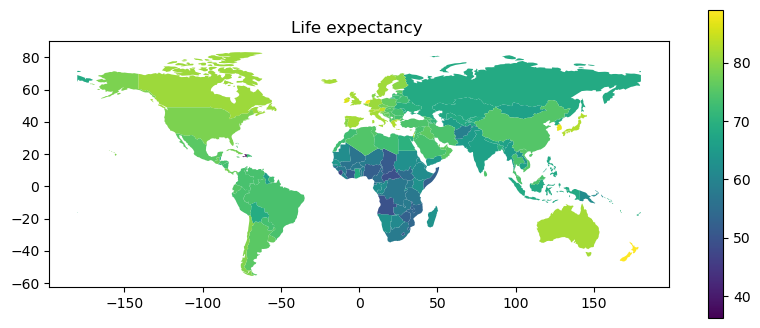

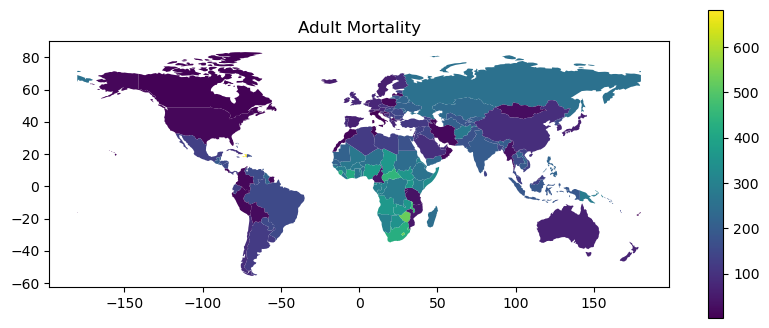

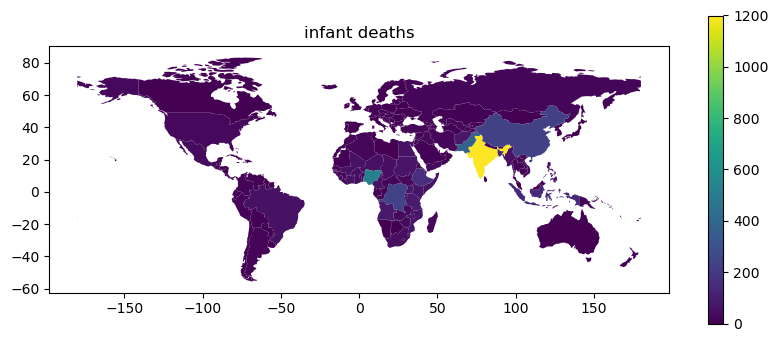

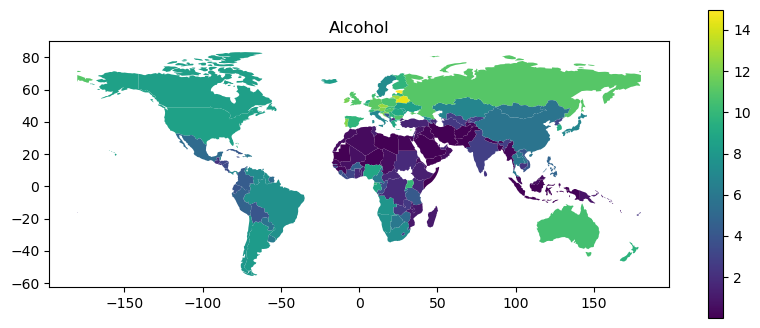

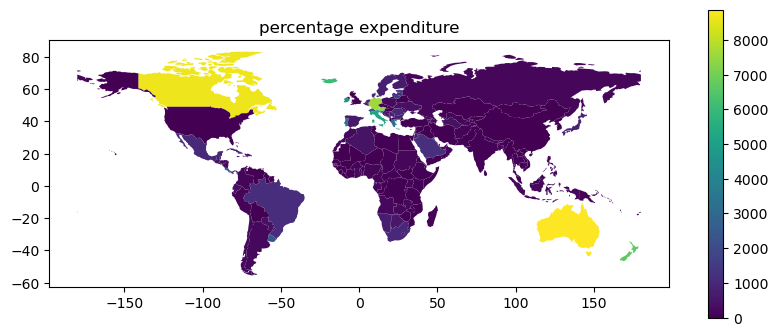

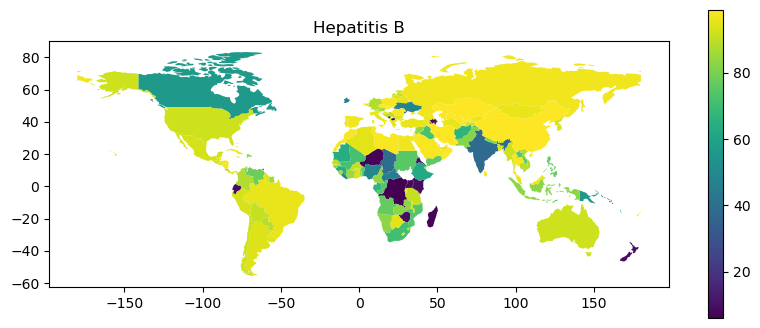

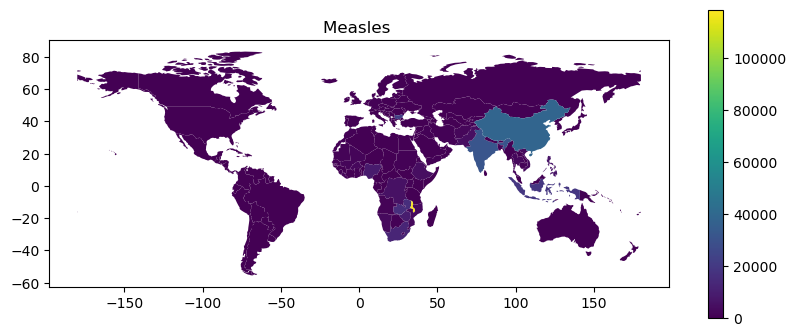

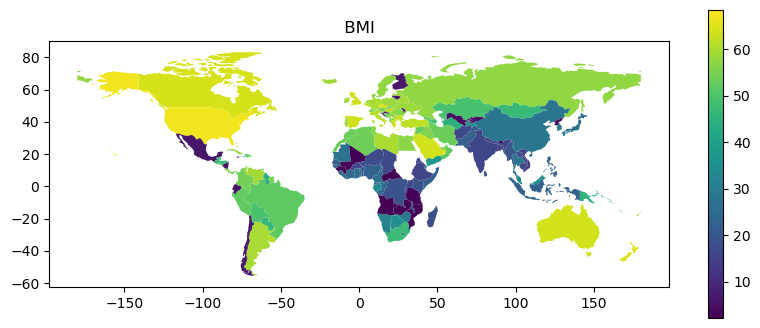

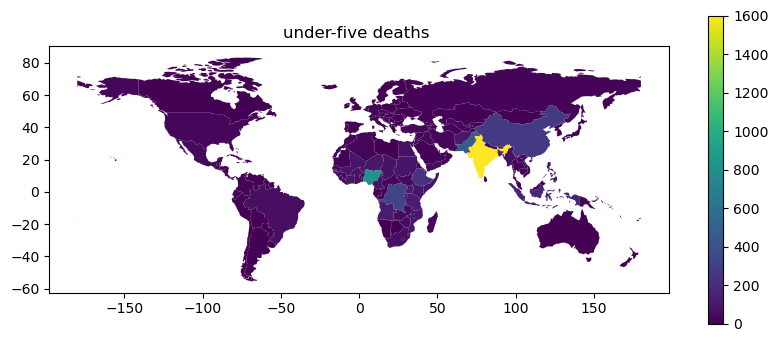

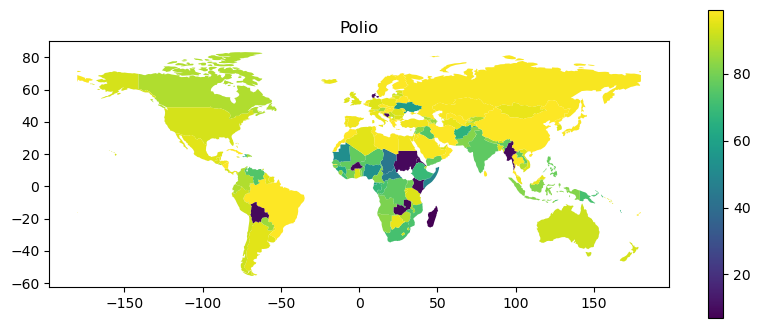

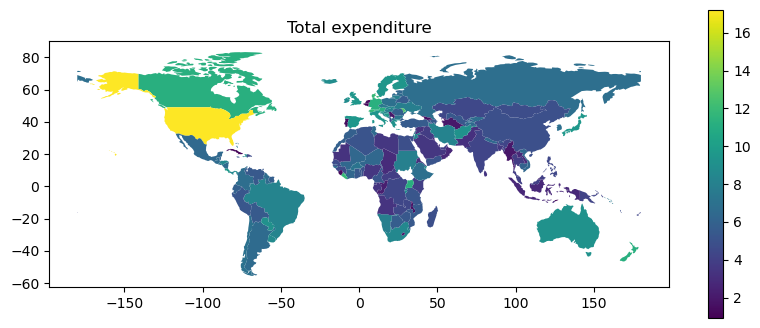

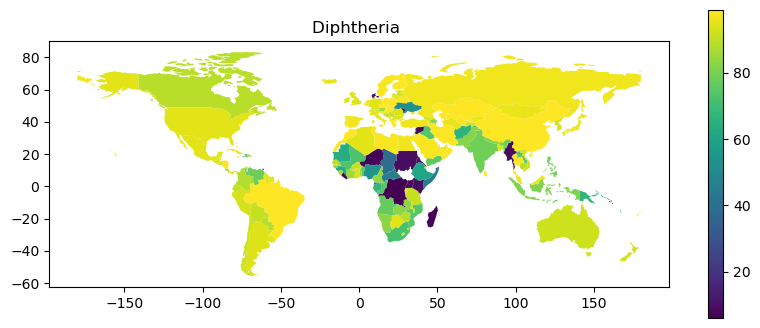

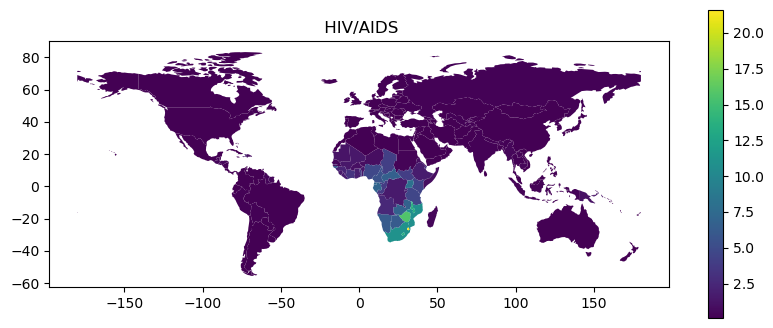

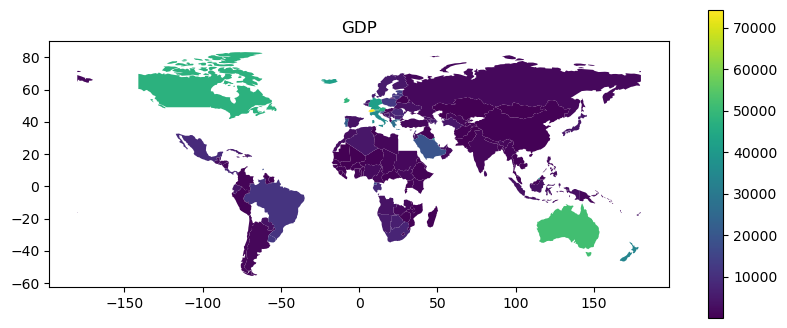

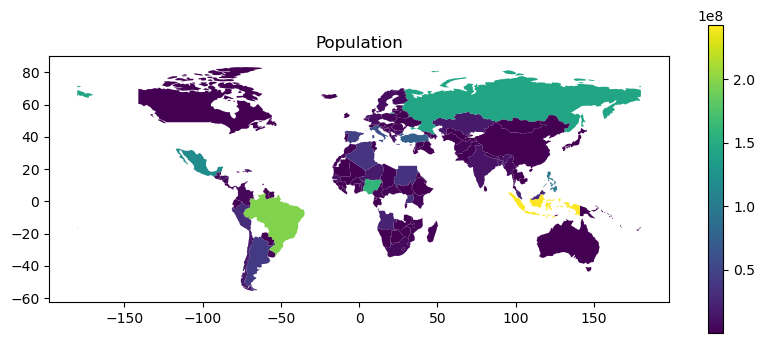

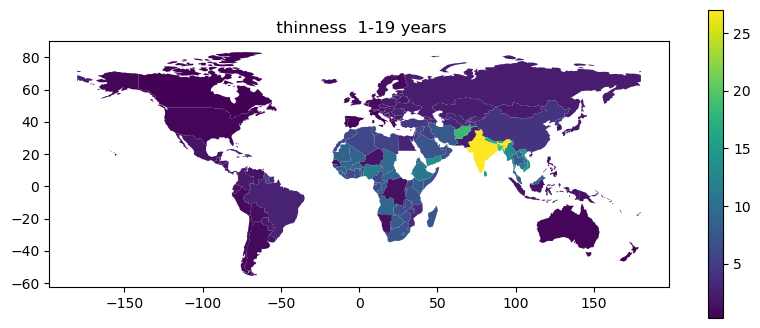

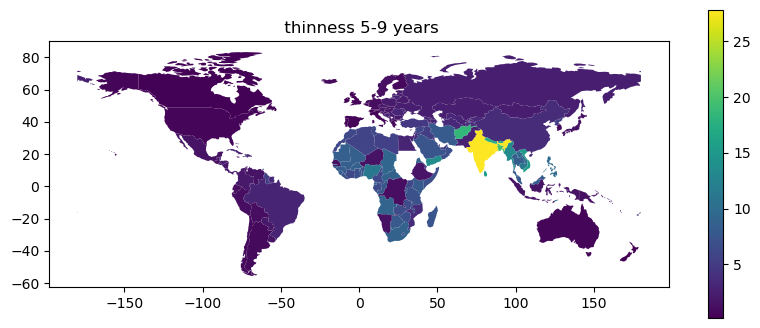

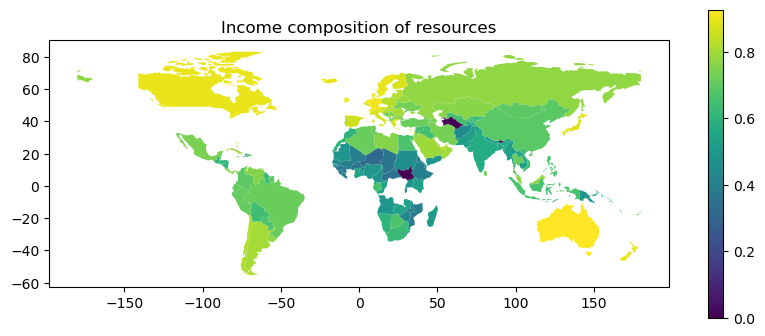

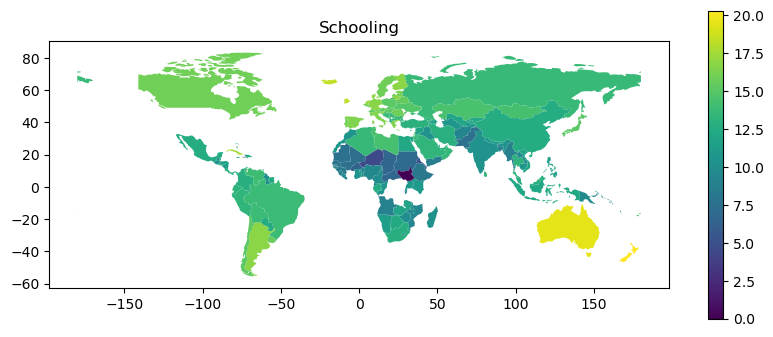

In [7]:
class GeoPlotter():

    def __init__(self, df=None):
        if df == None:
            self.df = DataPipeline().clean(["name_change"])
        elif 'ISO_A3' not in df.columns:
            raise ValueError("This dataframe does not have an ISO_A3 column. Please use the DataPipeline change_name transform to prepare it for plotting")
        else: 
            self.df = df
        world = gpd.read_file('worldmap.gpkg')
        self.merged = world.merge(self.df, left_on='ISO_A3', right_on='ISO_A3')


    def plot(self, col_name, year, continent='all', country='all'):
        fig, ax = plt.subplots(1, figsize=(10, 4))
        df = self.merged[self.merged['Year'].astype(str) == year]
        df.plot(column=col_name, ax=ax, legend=True)
        ax.set_title(col_name)
        plt.show()
    
    def animate(self, col_name, video_name):
        fig, ax = plt.subplots(1, figsize=(10, 7))

        def update(year):
            df = self.merged[self.merged['Year'].astype(str) == str(year)]
            df.plot(column=col_name, ax=ax)
            ax.set_title(col_name + "\n" + str(year))

        animation.writer = animation.writers['ffmpeg']
        ani = animation.FuncAnimation(fig, update, 
            frames=sorted(set(df['Year'])),
            interval=df['Year'].max() - df['Year'].min() / 10)
        ani.save(video_name)


gplt = GeoPlotter()
print(gplt.df.columns)
for col in gplt.df.columns:
    if col not in ['Country', 'Status', 'Year', 'ISO_A3']:
        gplt.plot(col, '2010')
        plt.show()

# gplt.animate('Life expectancy ', 'life_expectancy.mp4', )

In [8]:
corruption = pd.read_csv('../data/Corruption/1afc8046-c578-44ec-9a05-8319b37bc2ed_Data.csv')
print(corruption.isna().sum())

Country Name     3
Country Code     5
Series Name      5
Series Code      5
1996 [YR1996]    5
1998 [YR1998]    5
2000 [YR2000]    5
2002 [YR2002]    5
2003 [YR2003]    5
2004 [YR2004]    5
2005 [YR2005]    5
2006 [YR2006]    5
2007 [YR2007]    5
2008 [YR2008]    5
2009 [YR2009]    5
2010 [YR2010]    5
2011 [YR2011]    5
2012 [YR2012]    5
2013 [YR2013]    5
2014 [YR2014]    5
2015 [YR2015]    5
2016 [YR2016]    5
2017 [YR2017]    5
2018 [YR2018]    5
2019 [YR2019]    5
2020 [YR2020]    5
2021 [YR2021]    5
2022 [YR2022]    5
dtype: int64
